In [1]:
import pandas as pd
import collections
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from collections import OrderedDict

In [2]:
df = pd.read_csv("posts.csv", delimiter=";")

In [3]:
df.head()

,_id,registrationNumber,body,type,title
0,60783efceee6c61821bf1c96,86,"If COVID-19 is spreading in your community, st...",NaN,COVID-19
1,60783efceee6c61821bf1c97,86,"If COVID-19 is spreading in your community, st...",NaN,COVID-19
2,60783efceee6c61821bf1c98,86,"If COVID-19 is spreading in your community, st...",NaN,COVID-19
3,60783efceee6c61821bf1c99,86,"If COVID-19 is spreading in your community, st...",NaN,COVID-19
4,60783efceee6c61821bf1c9a,86,"If COVID-19 is spreading in your community, st...",NaN,COVID-19


In [4]:
def insert_space(title):
    title = ' '+title
    title += ' '
    return title

In [5]:
#df['date'].apply(lambda x: insert_space(x, 9), axis=1)
df['title']=df['title'].apply(lambda x: insert_space(x))

In [6]:
data = df["body"].values  + df["title"].values

In [7]:
data

array(['If COVID-19 is spreading in your community, stay safe by taking some simple precautions, such as physical distancing, wearing a mask, keeping rooms well ventilated, avoiding crowds, cleaning your hands, and coughing into a bent elbow or tissue. Check local advice where you live and work. Do it all! COVID-19 ',
       'If COVID-19 is spreading in your community, stay safe by taking some simple precautions, such as physical distancing, wearing a mask, keeping rooms well ventilated, avoiding crowds, cleaning your hands, and coughing into a bent elbow or tissue. Check local advice where you live and work. Do it all! COVID-19 ',
       'If COVID-19 is spreading in your community, stay safe by taking some simple precautions, such as physical distancing, wearing a mask, keeping rooms well ventilated, avoiding crowds, cleaning your hands, and coughing into a bent elbow or tissue. Check local advice where you live and work. Do it all! COVID-19 ',
       'If COVID-19 is spreading in your

In [8]:

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

/home/emna/.local/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
embeddings

array([[-0.10415278, -0.27255258,  0.5402934 , ...,  0.21019188,
        -0.19065295,  0.46847424],
       [-0.10415278, -0.27255258,  0.5402934 , ...,  0.21019188,
        -0.19065295,  0.46847424],
       [-0.10415278, -0.27255258,  0.5402934 , ...,  0.21019188,
        -0.19065295,  0.46847424],
       ...,
       [ 0.03604591, -0.20686609,  0.8149671 , ...,  0.4037903 ,
        -0.13154879, -0.6104717 ],
       [ 0.04271022, -0.2057677 ,  0.8016537 , ...,  0.40670797,
        -0.13603146, -0.61572975],
       [ 0.2855761 , -0.19349541,  0.6472508 , ...,  0.1870962 ,
        -0.57216555, -1.6035346 ]], dtype=float32)

In [10]:
len(embeddings)

58

In [11]:
for i in embeddings : 
    print(len(i))
    break

768


In [12]:
# umap is a  dimensionality reduction algorithm
umap_embeddings = umap.UMAP(n_neighbors=2, 
                            n_components=3, 
                            metric='cosine').fit_transform(embeddings)

In [13]:
#umap_embeddings

In [14]:
len(umap_embeddings)

58

In [15]:
len(umap_embeddings[1])  # n_components

3

In [16]:
cluster = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)


In [17]:
cluster.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       2, 0, 0, 2, 0, 1, 0, 1, 1, 1, 2, 2, 2, 1])

In [18]:
len(cluster.labels_)

58

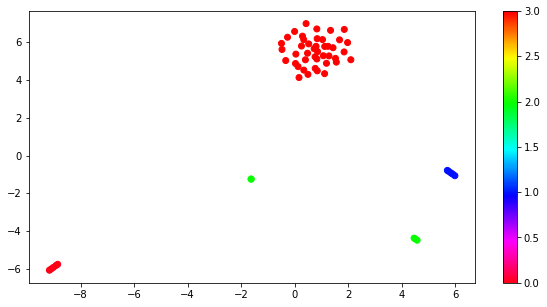

In [19]:

# Prepare data
umap_data = umap.UMAP(n_neighbors=2, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels,  cmap='hsv_r')
plt.colorbar()


In [20]:
result.head()

,x,y,labels
0,1.240688,5.784538,3
1,0.722332,5.662420,3
2,1.181830,4.885345,3
3,0.395162,5.070634,3
4,0.839024,4.485486,3


In [21]:
# create a single document for each cluster of documents:
#all documents in a single cluster are considered as one documments

docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})


In [22]:
docs_df.head(2)

,Doc,Topic,Doc_ID
0,"If COVID-19 is spreading in your community, st...",3,0
1,"If COVID-19 is spreading in your community, st...",3,1


In [23]:
docs_per_topic

,Topic,Doc
0,0,Last year's retreat was so successful that we ...
1,1,We announce an amazing team building the month...
2,2,I am sorry to report that Jane Doe has been ho...
3,3,"If COVID-19 is spreading in your community, st..."


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [25]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, docs, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    topic_sizes = extract_topic_sizes(docs)
    # sort the dict to get the HOT topics ordered
    top_n_words = OrderedDict(top_n_words)
    key_order = list(topic_sizes["Topic"].values)
    for k in key_order:
        top_n_words.move_to_end(k)
    top_n_words = dict(top_n_words)    
    return top_n_words
    

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, docs_df, n=10)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
3,3,43
0,0,5
1,1,5
2,2,5


In [26]:
def word_clouds(top_words):
    my_dict = dict()
    word_cloud = list()
    for key, value in top_words.items():
        words = list()
        for i in value:
            my_dict["text"] = i[0]
            my_dict["weight"] = i[1]
            words.append(my_dict.copy())       
        word_cloud.append(words)
    return word_cloud

In [27]:
word_cloud = word_clouds(top_n_words)

In [28]:
# my_dict = dict()
# word_cloud = list()
# for key, value in top_n_words.items():
#     words = list()
#     for i in value:
#         my_dict["text"] = i[0]
#         my_dict["weight"] = i[1]
#         words.append(my_dict.copy())
       
#     word_cloud.append(words)


In [31]:
word_cloud[:2]

[[{'text': 'hands', 'weight': 0.009652996608156673},
  {'text': 'ventilated', 'weight': 0.009652996608156673},
  {'text': 'distancing', 'weight': 0.009652996608156673},
  {'text': 'crowds', 'weight': 0.009652996608156673},
  {'text': 'rooms', 'weight': 0.009652996608156673},
  {'text': 'safe', 'weight': 0.009652996608156673},
  {'text': 'coughing', 'weight': 0.009652996608156673},
  {'text': 'precautions', 'weight': 0.009652996608156673},
  {'text': 'simple', 'weight': 0.009652996608156673},
  {'text': 'community', 'weight': 0.009652996608156673}],
 [{'text': 'announcement', 'weight': 0.0643182295086553},
  {'text': 'expect', 'weight': 0.05769800107555148},
  {'text': 'years', 'weight': 0.05769800107555148},
  {'text': 'attend', 'weight': 0.043731114675149015},
  {'text': 'sami', 'weight': 0.043731114675149015},
  {'text': 'visit', 'weight': 0.043731114675149015},
  {'text': 'tell', 'weight': 0.043731114675149015},
  {'text': 'employees', 'weight': 0.043731114675149015},
  {'text': '00